In [12]:
import numpy as np
import matplotlib.pyplot as plt
import msgpack as mp
import msgpack_numpy as mpn
import cv2
from tqdm import tqdm

In [13]:
_pth = r"E:\CMC\pyprojects\programs_rpi\programs\data\calibration\chess_board\webcam_color.msgpack"
with open(_pth, "rb") as f:
    _frames = list(mp.Unpacker(f, object_hook=mpn.decode))

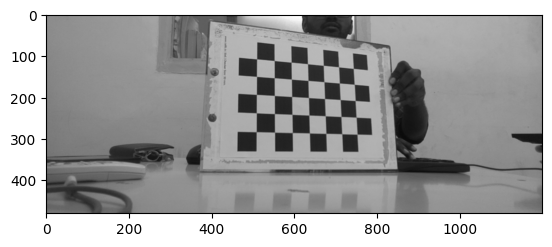

In [14]:
plt.imshow(cv2.cvtColor(_frames[0], cv2.COLOR_BGR2RGB))

In [15]:
# # termination criteria
# criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
# objp = np.zeros((6*4,3), np.float32)
# objp[:,:2] = np.mgrid[0:6,0:4].T.reshape(-1,2)

# # Arrays to store object points and image points from all the images.
# objpoints = [] # 3d point in real world space
# imgpoints = [] # 2d points in image plane.

# for _f in tqdm(_frames):
#     # Find the chess board corners
#     ret, corners = cv2.findChessboardCorners(_f, (6,4), None)

#     # If found, add object points, image points (after refining them)
#     if ret == True:
#         objpoints.append(objp)
#         corners2 = cv2.cornerSubPix(_f,corners, (11,11), (-1,-1), criteria)
#         imgpoints.append(corners2)

In [16]:
useDeng = False
cameraNumber = 4
useFisheye = True

patternSize = (6, 4)
squareSize = 30
imgSize = (1200, 480)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)


def construct3DPoints(patternSize, squareSize):
    X = np.zeros((patternSize[0] * patternSize[1], 3), np.float32)
    X[:, :2] = np.mgrid[0 : patternSize[0], 0 : patternSize[1]].T.reshape(-1, 2)
    X = X * squareSize
    return X


boardPoints = construct3DPoints(patternSize, squareSize)
worldPoints = []
imagePoints = []

In [17]:
def undistortFisheye(imgpath, K, D, DIM, axis, method, scale, corners):
    img = cv2.imread(imgpath)
    """
    new_K = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(K, D, DIM, np.eye(3), balance=0)
    new_K = K.copy()
    new_K[0,0]=K[0,0]*scale
    new_K[1,1]=K[1,1]*scale
    """
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(
        K, D, np.eye(3), K, DIM, cv2.CV_16SC2
    )
    undistorted_img = cv2.remap(
        img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT
    )

    fx = K[0, 0]
    fy = K[1, 1]
    cx = K[0, 2]
    cy = K[1, 2]
    undCorners_norm = cv2.fisheye.undistortPoints(corners, K, D)
    undCorners_norm = undCorners_norm.reshape(-1, 2)
    undistCorners = np.zeros_like(undCorners_norm)
    for i, (x, y) in enumerate(undCorners_norm):
        px = x * fx + cx
        py = y * fy + cy
        undistCorners[i, 0] = px
        undistCorners[i, 1] = py
    cv2.drawChessboardCorners(undistorted_img, patternSize, undistCorners, _)

    axs[axis].imshow(undistorted_img[:, :, ::-1])
    axs[axis].axis("off")
    axs[axis].set_title("undistort " + method)
    # cv2.imwrite('undistort'+method+'.png', undistorted_img)

    return corners, undistCorners


def undistortPinhole(imgpath, K, D, DIM, axis, method, corners):
    img = cv2.imread(imgpath)

    new_K, roi = cv2.getOptimalNewCameraMatrix(K, D, DIM, 1, DIM)
    undistorted_img = cv2.undistort(img, K, D, None, new_K)

    undCorners_norm = cv2.undistortPoints(corners, K, D).reshape(-1, 2)
    # remove normalization
    fx = new_K[0, 0]
    fy = new_K[1, 1]
    cx = new_K[0, 2]
    cy = new_K[1, 2]
    undistCorners = np.zeros_like(undCorners_norm)
    for i, (x, y) in enumerate(undCorners_norm):
        px = x * fx + cx
        py = y * fy + cy
        undistCorners[i, 0] = px
        undistCorners[i, 1] = py
    cv2.drawChessboardCorners(undistorted_img, patternSize, undistCorners, _)
    axs[axis].imshow(undistorted_img[:, :, ::-1])
    axs[axis].axis("off")
    axs[axis].set_title("undistorted " + method)

In [18]:
counter = 0
for _f in tqdm(_frames):
    gray = _f
    ret, corners = cv2.findChessboardCorners(gray, patternSize, None)
    if ret == True:
        cornersRefined = cv2.cornerSubPix(gray, corners, (7, 7), (-1, -1), criteria)
        imagePoints.append(cornersRefined)
        worldPoints.append(boardPoints)
        counter += 1
        """cv2.drawChessboardCorners(img, patternSize, cornersRefined, ret)
        plt.figure(figsize=(4, 3), dpi=200)
        plt.imshow(img[:,:,::-1])
        plt.axis('off')
        plt.title(fname)"""

100%|██████████| 1042/1042 [02:26<00:00,  7.09it/s]


In [19]:
if useFisheye:
    flagsCalib = (
        cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC
        + cv2.fisheye.CALIB_FIX_SKEW
        + cv2.fisheye.CALIB_CHECK_COND
    )
    calibrateCriteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-12)
    ret, cameraMatrix, k, R, t = cv2.fisheye.calibrate(
        np.expand_dims(np.asarray(worldPoints), -2),
        imagePoints,
        imgSize,
        None,
        None,
        flags=flagsCalib,
        criteria=calibrateCriteria,
    )
else:
    flagsCalib = cv2.CALIB_RATIONAL_MODEL
    ret, cameraMatrix, k, rvecs, tvecs = cv2.calibrateCamera(
        worldPoints, imagePoints, imgSize, None, None, flags=flagsCalib
    )

# print("Using "+str(counter)+" of "+str(len(images))+" images")
print("RMS re-projection error:", ret)
print("Camera Matrix:\n", cameraMatrix)
print("Distortion Parameters:\n", k)

RMS re-projection error: 0.0970721579239421
Camera Matrix:
 [[763.72536048   0.         599.04503711]
 [  0.         769.55041105 238.82233928]
 [  0.           0.           1.        ]]
Distortion Parameters:
 [[  0.22375937]
 [  1.87350353]
 [-18.13791517]
 [ 69.82359716]]


In [21]:
import toml

data = toml.load("../settings.toml")
data["calibration"]["camera_matrix"] = cameraMatrix.tolist()
data["calibration"]["dist_coeffs"] = k.tolist()
data["camera"]["resolution"] = (1280, 480)
with open("../calib_test_fisheye.toml", "w") as f:
    toml.dump(data, f)

In [ ]:
def estimate_camera_parameters(object_points, image_points, image_size):
    from scipy.optimize import least_squares

    def reprojection_error(params, object_points, image_points, image_size):
        # Unpack parameters
        fx, fy, cx, cy, k1, k2, k3, p1, p2 = params[:9]
        rotation_vector = params[9:12]
        translation_vector = params[12:15]

        # Camera matrix
        camera_matrix = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

        # Distortion coefficients
        dist_coeffs = np.array([k1, k2, p1, p2, k3])

        # Project points using the camera matrix and distortion coefficients
        projected_points, _ = cv2.projectPoints(
            object_points,
            rotation_vector,
            translation_vector,
            camera_matrix,
            dist_coeffs,
        )
        projected_points = projected_points.squeeze()

        return (projected_points - image_points).ravel()

    initial_guess = np.array(
        [1, 1, image_size[1] / 2, image_size[0] / 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    )
    result = least_squares(
        reprojection_error,
        initial_guess,
        args=(object_points, image_points, image_size),
    )

    params = result.x
    fx, fy, cx, cy, k1, k2, k3, p1, p2 = params[:9]
    rotation_vector = params[9:12]
    translation_vector = params[12:15]

    camera_matrix = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

    dist_coeffs = np.array([k1, k2, p1, p2, k3])

    return camera_matrix, dist_coeffs, rotation_vector, translation_vector


# Define object points in the real world
object_points = np.zeros((pattern_size[0] * pattern_size[1], 3), np.float32)
object_points[:, :2] = np.mgrid[0 : pattern_size[0], 0 : pattern_size[1]].T.reshape(
    -1, 2
)

# Image size
image_size = (image.shape[0], image.shape[1])

# Detect corners in multiple images and stack the object points and image points
object_points_list = []
image_points_list = []

for image_path in image_paths:
    image_points = detect_chessboard_corners(image_path, pattern_size)
    image_points_list.append(image_points)
    object_points_list.append(object_points)

object_points_array = np.array(object_points_list)
image_points_array = np.array(image_points_list)

camera_matrix, dist_coeffs, rotation_vector, translation_vector = (
    estimate_camera_parameters(object_points_array, image_points_array, image_size)
)

print("Camera Matrix:\n", camera_matrix)
print("Distortion Coefficients:\n", dist_coeffs)
print("Rotation Vector:\n", rotation_vector)
print("Translation Vector:\n", translation_vector)

In [ ]:
calibration_flags = (
    cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC
    + cv2.fisheye.CALIB_CHECK_COND
    + cv2.fisheye.CALIB_FIX_SKEW
)

N_OK = len(objpoints)
K = np.zeros((3, 3))
D = np.zeros((4, 1))
rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
rms, _, _, _, _ = cv2.fisheye.calibrate(
    processed_object_points,
    processed_image_points,
    gray.shape[::-1],
    K,
    D,
    rvecs,
    tvecs,
    calibration_flags,
    (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6),
)

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\fisheye.cpp:753: error: (-215:Assertion failed) objectPoints.type() == CV_32FC3 || objectPoints.type() == CV_64FC3 in function 'cv::fisheye::calibrate'


In [ ]:
calibration_flags = (
    cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC
    + cv2.fisheye.CALIB_CHECK_COND
    + cv2.fisheye.CALIB_FIX_SKEW
)

N_OK = len(objpoints)
K = np.zeros((3, 3))
D = np.zeros((4, 1))
rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
rms, _, _, _, _ = cv2.fisheye.calibrate(
    processed_object_points.reshape(-1, 1, 3),
    processed_image_points.reshape(-1, 1, 3),
    gray.shape[::-1],
    K,
    D,
    rvecs,
    tvecs,
    calibration_flags,
    (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6),
)

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\fisheye.cpp:752: error: (-215:Assertion failed) !objectPoints.empty() && !imagePoints.empty() && objectPoints.total() == imagePoints.total() in function 'cv::fisheye::calibrate'


In [ ]:
processed_image_points.reshape(-1, 1, 3)

array([[[0., 0., 0.]],

       [[1., 0., 0.]],

       [[2., 0., 0.]],

       ...,

       [[3., 3., 0.]],

       [[4., 3., 0.]],

       [[5., 3., 0.]]], dtype=float32)